# Задание 5.

Загрузите [данные по изменению температуры поверхности земли](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data). Для этого может понадобится зарегистрироваться на [Kaggle](https://kaggle.com). Затем нужно будет работать с данными, которые содержатся в файле **GlobalLandTemperaturesByMajorCity.csv**

**NB** Все подсчеты необходимо делать с помощью `PySpark`, без применения `pandas api`. Можно использоать `SQL`.

In [1]:
import zipfile

import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

%matplotlib inline

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("PySpark") \
    .getOrCreate()

with zipfile.ZipFile("archive.zip") as z:
    with z.open("GlobalLandTemperaturesByMajorCity.csv") as f:
        pandas_df = pd.read_csv(f)
        df = spark.createDataFrame(pandas_df)

df.show(10)

23/11/14 01:30:45 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.1.140 instead (on interface wlxc0252fe609b2)
23/11/14 01:30:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/14 01:30:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/14 01:30:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1849-01-01|            26.704|                        1.435|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-02-01|            27.434|                        1.362|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-03-01|            28.101|                        1.612|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-04-01|             26.14|           1.3869999999999998|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-05-01|            25.427|                          1.2|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-06-01|            24.844|                        1.402|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-07-01|24.058000000000003|                        1.254|Abidjan|Côte

# Задание 3.1 (1 балл)

В последующих заданиях будут учитываться данные начиная с 01.01.1950. Для этого создайте новый `DataFrame`, в котором удалены все строки до 01.01.1950. Используйте созданный DataFrame в последующих заданиях.  

In [2]:
df = df.withColumn("dt", F.to_date(df.dt))
df = df.filter(df.dt >= F.lit("1950-01-01"))
df.show(5)

+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1950-01-01|26.773000000000003|                        0.239|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-02-01|            27.527|                        0.348|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-03-01|            28.344|                        0.431|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-04-01|             27.83|                        0.467|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-05-01|            26.896|                        0.248|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
only showing top 5 rows



# Задание 3.2 (2 балла)

Постройте график среднегодовых температур в городе Торонто.

<Axes: xlabel='Year'>

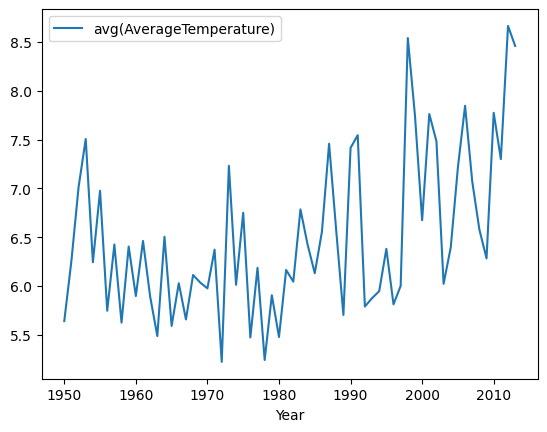

In [3]:
toronto = df.filter(df.City == "Toronto")
toronto_average_temp_year = toronto.groupBy(F.year("dt").alias("Year")).avg("AverageTemperature").sort("Year")
toronto_average_temp_year.toPandas().plot(x="Year", y="avg(AverageTemperature)")

# Задание 3.3 (2 балла)

Найдите город, для которого выборочная дисперсия температур на приведенных данных максимальна. 

In [4]:
df = df.fillna(0, subset=["AverageTemperature"]) # had to do it for variance to calc properly
df.groupBy("City").agg(F.variance("AverageTemperature").alias("TemperatureVariance")).orderBy(F.desc("TemperatureVariance")).select(["City", "TemperatureVariance"]).first()

Row(City='Harbin', TemperatureVariance=218.6362199435101)

# Задание 3.4 (4 балла)

На одной оси постройте графики, отображающие:
1. Зависимость выборочной дисперсии температур от широты города (Latitude).
2. Зависимость средней температуры в январе 1975 года от широты города (Latitude).
3. Зависимость средней температуры в июле 1975 года от широты города (Latitude).

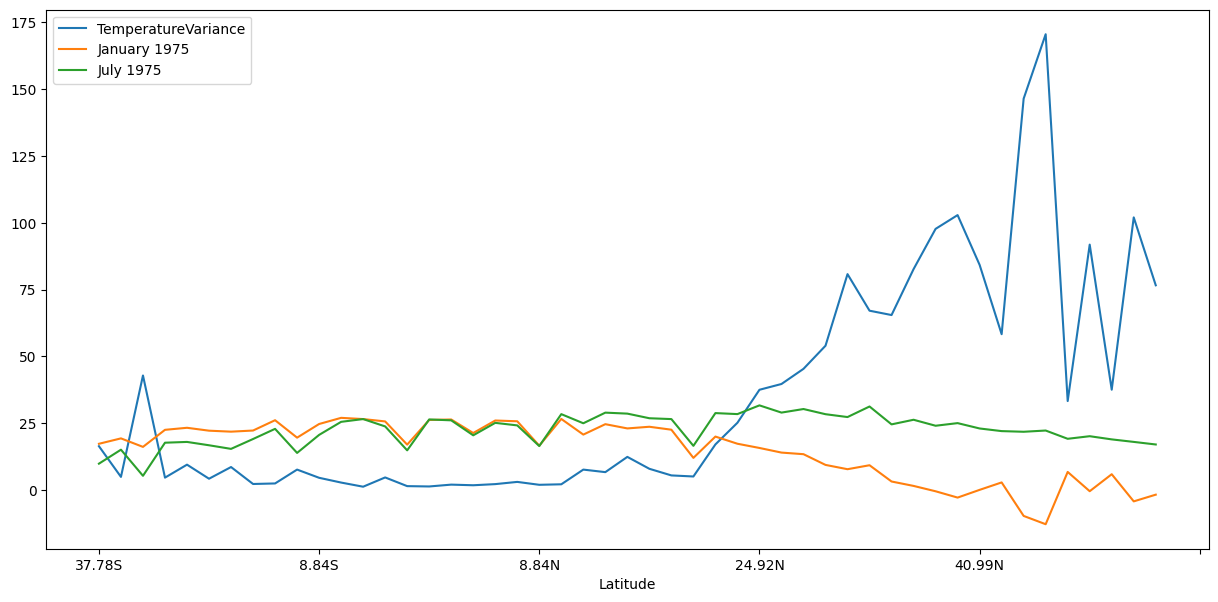

In [5]:
%matplotlib inline
from pyspark.sql.types import FloatType

# calc all aggregations
temperature_variance = df.groupBy("Latitude").agg({"AverageTemperature": "variance"}).withColumnRenamed("variance(AverageTemperature)", "TemperatureVariance")
january_1975 = df.filter(F.col("dt") == "1975-01-01").groupBy("Latitude").agg({"AverageTemperature": "mean"}).withColumnRenamed("avg(AverageTemperature)", "January 1975")
july_1975 = df.filter(F.col("dt") == "1975-07-01").groupBy("Latitude").agg({"AverageTemperature": "mean"}).withColumnRenamed("avg(AverageTemperature)", "July 1975")


merged_df = temperature_variance.join(january_1975, "Latitude").join(july_1975, "Latitude")
float_latitude = F.udf(lambda x: -float(x[:-1]) if x.endswith("S") else float(x[:-1]), FloatType())
merged_df = merged_df.withColumn("FloatLatitude", float_latitude(F.col("Latitude"))).orderBy("FloatLatitude")
merged_df.toPandas().plot(x="Latitude", y=["TemperatureVariance", "January 1975", "July 1975"], kind="line", figsize=(15, 7))

plt.show()

# Задание 3.5 (6 баллов)

Посчитайте данные по среднегодовой температуре в Санкт-Петербурге. Определите года, в которых средняя температура была выше, чем в предыдущем  и последующем году. Постройте график среднегодовой температуры и обозначьте на нём найденные года (произвольным образом). 

Постройте модель линейной регрессии (можно использовать [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)): $\mathbb{год} \rightarrow \mathbb{средняя\_температура}$. Отобразите прямую на предыдущем графике. 

23/11/14 01:31:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 01:31:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 01:31:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 01:31:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 01:31:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 01:31:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 0

+----+-----------------+------------------+------------------+
|Year|        mean_temp|          lag_temp|         lead_temp|
+----+-----------------+------------------+------------------+
|1953|4.840083333333333| 3.749333333333333|             4.454|
|1957|4.856249999999999|2.5654999999999997|3.2618333333333336|
|1959|5.026000000000001|3.2618333333333336| 4.108249999999999|
+----+-----------------+------------------+------------------+
only showing top 3 rows

None


23/11/14 01:31:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 01:31:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 01:31:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 01:31:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 01:31:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 01:31:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/14 0

IllegalArgumentException: requirement failed: Column mean_temp must be of type class org.apache.spark.ml.linalg.VectorUDT:struct<type:tinyint,size:int,indices:array<int>,values:array<double>> but was actually class org.apache.spark.sql.types.DoubleType$:double.

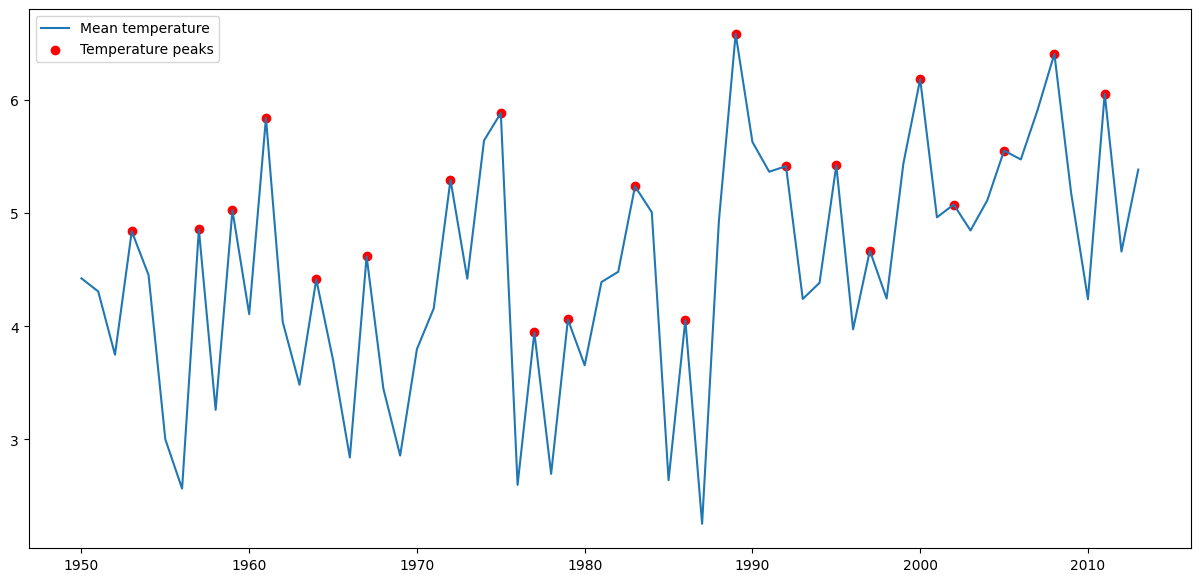

In [6]:
import numpy as np
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window

spb_data = df.filter(df["City"] == "Saint Petersburg")
spb_mean = spb_data.groupBy(F.year("dt").alias("Year")).agg(F.avg("AverageTemperature").alias("mean_temp")).orderBy("Year")
# temp_peaks = spb_mean.filter(spb_mean["mean_temp"] > F.lag(spb_mean["mean_temp"],1) & spb_mean["mean_temp"] > F.lead(spb_mean["mean_temp"], 1))
# temp_peaks = spb_mean.filter((spb_mean["mean_temp"] > F.lag(spb_mean["mean_temp"], 1)) & (spb_mean["mean_temp"] > F.lead(spb_mean["mean_temp"], 1)))

# Create lag and lead column using window functions with a Window specified by "date"
windowSpec = Window.orderBy("Year")
spb_mean = spb_mean.withColumn("lag_temp", F.lag("mean_temp").over(windowSpec))
spb_mean = spb_mean.withColumn("lead_temp", F.lead("mean_temp").over(windowSpec))

# Filter rows where "mean_temp" is greater than both lag and lead values
temp_peaks = spb_mean.filter((spb_mean["mean_temp"] > spb_mean["lag_temp"]) & (spb_mean["mean_temp"] > spb_mean["lead_temp"]))
print(temp_peaks.show(3))


spb_mean_list = spb_mean.select("mean_temp").rdd.flatMap(lambda x: x).collect()
spb_years = spb_mean.select("Year").rdd.flatMap(lambda x: x).collect()

temp_peaks_list = temp_peaks.select("mean_temp").rdd.flatMap(lambda x: x).collect()
temp_peaks_years = temp_peaks.select("Year").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(15, 7))
plt.plot(spb_years, spb_mean_list, label="Mean temperature")
plt.scatter(temp_peaks_years, temp_peaks_list, color="r", label="Temperature peaks")
plt.legend()

model = LinearRegression(featuresCol="mean_temp", labelCol="Year").fit(spb_mean)
print(f'Model predictions : {model.evaluate(range(len(spb_mean_list))).predictions.show(3)}')

# Задание 3.6 (4 балла)

Найдите города, для которых: 
1. Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.
2. Самая большая средняя разница между средней температурой января и средней температурой июля.
3. Наибольшее среднее количество месяцев с отрицательной температурой в году.

In [7]:
from pyspark.sql.functions import max, min

max_min_temp_diff = df.groupBy("City").agg((max("AverageTemperature") - min("AverageTemperature")).alias("TemperatureDifference"))
max_min_temp_diff.orderBy(F.col("TemperatureDifference").desc()).first()

Row(City='Harbin', TemperatureDifference=49.278999999999996)

In [8]:
from pyspark.sql.functions import avg

jan_jul_temp_diff = df.groupBy("City").agg((avg("AverageTemperature").alias("AverageTempJan") - avg("AverageTemperature").alias("AverageTempJul")).alias("TemperatureDifference"))
jan_jul_temp_diff.orderBy(F.col("TemperatureDifference").desc()).first()

Row(City='Alexandria', TemperatureDifference=0.0)

# Задание 3.7 (3 балла)

Отобразите города на карте, например с помощью [geopandas/folium](https://geopandas.org/en/stable/gallery/plotting_with_folium.html) или [plotly](https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html). Причем цвет метки должен соответствовать средней температуре в январе за последние 10 лет. 


**\***(+3 балла). Вычислите прямую с "трендом" по изменению средней температуры за год в каждом городе в период 1950-2013 (можно с помощью линейной регрессии, как в задании **3.5**). Отобразите города цветом, который зависит от угла наклона этой прямой. 


**\***(+1 балл) В дополнение к предыдущему пункту, используйте библиотеку [pwlf](https://pypi.org/project/pwlf/) с фиксированным числом сегментов и визуализируйте угол наклона последнего сегмента. 

# *Задание 3.8 (8 баллов)

Цель - создать проект, который как минимум включает:
1. Использование юнит-тестов ([pytest](https://pytest.org)).
2. Применение средств форматирования и проверки исходного кода (например: [isort](https://pycqa.github.io/isort/), [black](https://black.readthedocs.io/en/stable/), [flake8](https://flake8.pycqa.org/en/latest/), [mypy](https://mypy.readthedocs.io/en/stable/)).
3. Спецификацию проекта в [pyproject.toml](https://pip.pypa.io/en/stable/reference/build-system/pyproject-toml/).
4. Использование утилит для работы с командной строкой ([argparse](https://docs.python.org/3/library/argparse.html), [click](https://click.palletsprojects.com/en/8.1.x/) и т.п.)
5. Сборку проекта в Wheel-файл.

Проект должен быть загружен в репозиторий. Функционал - произвольный, но должны использоваться данные из этого домашнего задания. Сам файл передается в качестве первого аргумента командной строки.  Например:

> python3 -m homeproject.app GlobalLandTemperaturesByMajorCity.csv 1980

Выдает самый жаркий месяц и город по наблюдениям за 1980 год.

*Ссылка на проект*